> **Note:** This notebook focuses exclusively on the implementation of **Transfer Learning** using ResNet-18. Detailed explanations of fundamental concepts (CNN architecture, data preprocessing, and evaluation metrics) have been omitted as they are thoroughly documented in the previous assignment (**Homework #4**). All markdown commentary in this notebook discusses only the changes and adaptations made to the original workflow to support transfer learning.

In [173]:
# Import Torch
import torch
from torch import nn

# Import Torchvision
import torchvision
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

# Other
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [174]:
# HYPERPARAMETERS
EPOCHS = 7
BATCH_SIZE = 32
LEARNING_RATE = 0.0001 # Lower lr for transfer learning
RANDOM_SEED = 242

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [175]:

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} deivce")

Using cuda deivce


### Data Preparation & Adaptation

To adapt the FashionMNIST dataset for transfer learning with ResNet-18, I made two significant changes to the preprocessing pipeline:

* **Channel Expansion:** Since ResNet models are pre-trained on RGB images and expect 3 input channels, I modified the transform to duplicate the single grayscale channel three times. This allows the model to process the input natively without modifying its internal architecture.
* **Resizing Strategy:** I adjusted the image resolution to ensure effective feature extraction.
    * *Initial Approach:* I started with the original **28x28** resolution, but the model struggled because the spatial dimensions were pooled down to nothing before reaching the final layers.
    * *Adjustment:* I considered the standard ResNet input of **224x224**, but found it computationally expensive and unnecessary for this specific task.
    * *Final Decision:* I settled on resizing images to **64x64**. This "sweet spot" provides enough spatial resolution for the deep network to retain useful features while keeping training times short and efficient.

In [176]:
# GET TRAIN DATASET
train_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

# CALCULATE MEAN & STD
imgs = train_data.data.float() / 255.0  # Scale 0-255 integers to 0-1 floats (the row data)
mean = imgs.mean().item()
std = imgs.std().item()

print(f"Calculated Mean: {mean:.4f}")
print(f"Calculated Std:  {std:.4f}")

# NORMALIZE TRAIN DATA
normalization = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # <---- added
    transforms.Resize((64, 64)), # <---- added
    ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_data.transform = normalization

Calculated Mean: 0.2860
Calculated Std:  0.3530


In [177]:
# GET TEST DATASET
test_data = datasets.FashionMNIST(
    root="../data", 
    train=False,  
    download=True,
    transform=normalization, 
)

# CREATE DATALOADERS
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

### Model Architecture: Fine-Tuning ResNet-18

I implemented a Fine-Tuning strategy using the **ResNet-18** architecture to adapt the model specifically for FashionMNIST.

* **Pre-trained Backbone:** I initialized the model with ImageNet weights (`ResNet18_Weights.DEFAULT`) and initially froze all parameters to preserve the robust lower-level feature extractors (edges, textures).
* **Fine-Tuning Strategy:** I explicitly **unfroze `layer4`** (the final convolutional block). This allows the model to retrain its highest-level filters to recognize clothing-specific patterns rather than generic ImageNet objects.
* **Classification Head:** I replaced the final fully connected layer with a new `nn.Linear` layer to map the features to the **10 FashionMNIST classes**.

*Note: I will discuss the specific reasoning behind unfreezing `layer4` and its impact on performance in detail in the Report Document.*

In [178]:
# Load Pretrained ResNet50 
fashionModel = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in fashionModel.parameters():
    param.requires_grad = False

# Unfreeze layer 4 (last Convolutional Block)
for param in fashionModel.layer4.parameters():
    param.requires_grad = True

# Get the number of inputs going into the final layer ( 2048 for ResNet50)
in_features = fashionModel.fc.in_features

# Replace the last FC layer with a new one for FashionMNIST 10 classes
fashionModel.fc = nn.Linear(in_features, 10)

# Move to Device
fashionModel = fashionModel.to(device)

### Training Configuration

For the training phase, I updated the optimization strategy to better suit the transfer learning process:

* **Optimizer:** I switched to the **Adam** optimizer, which adapts learning rates individually for each parameter. I implemented differential learning rates:
    * **Classifier (`fc`):** Trained at the base learning rate (`LEARNING_RATE`) to quickly learn the new class associations.
    * **Fine-Tuning (`layer4`):** Trained at a reduced rate (`LEARNING_RATE / 5`) to gently adjust the pre-trained high-level features without distorting them.
* **Scheduler:** I retained the **`StepLR`** scheduler to decay the learning rate by a factor of 0.1 every 4 epochs, ensuring the model settles into a precise minimum as training progresses.

In [179]:
# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# OPTIMIZER
optimizer = torch.optim.Adam([
    {'params': fashionModel.layer4.parameters(), 'lr': LEARNING_RATE / 5}, # Train layer4 slower
    {'params': fashionModel.fc.parameters(), 'lr': LEARNING_RATE}           # Train fc at normal speed
], weight_decay=1e-4)

# LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# ACCURACY FUNCTION
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,  y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [180]:

# TRAINING LOOP FUNCTION
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    # Put model in training mode
    model.train()
    # Initialize train loss and train acc
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(data_loader)):
        # Moving batch images and label to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (get logitis)
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Convert y_pred from logitis to predict label to calc acc 
        
        # 3. optimizer zero
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Devide train_loass and train_acc in num batch to get average loss, acc per batch
    train_loss /= len(data_loader) 
    train_acc /= len(data_loader)
    print(f"| Train Loss: {train_loss:.5f} Train accuracy: {train_acc:.4f}% |")

    return train_loss, train_acc

# TEST LOOP FUNCTION
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device: torch.device = device):

    """Perform Test loop on dataloader"""

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Moving batch images and label to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # input is label and not logits
 
        # Get average test loss and avarge accuracy per batch
        test_loss /= len(data_loader)  # Total loss is not a regular int and this line have to be insid the inference mode.
        test_acc /= len(data_loader)

    print(f"| Test loss: {test_loss:.5f} Test acc: {test_acc:.4f}% |\n")

    return test_loss, test_acc

In [181]:
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch} --------")

    train_loss, train_acc = train_step(model=fashionModel,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_loss, test_acc = test_step(model=fashionModel,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

    scheduler.step()
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

Epoch: 0 --------


100%|██████████| 1875/1875 [00:34<00:00, 54.76it/s]


| Train Loss: 0.49131 Train accuracy: 83.0250% |


100%|██████████| 313/313 [00:04<00:00, 74.89it/s]


| Test loss: 0.31482 Test acc: 88.6182% |

Current Learning Rate: 2e-05
Epoch: 1 --------


100%|██████████| 1875/1875 [00:34<00:00, 54.47it/s]


| Train Loss: 0.27703 Train accuracy: 89.9900% |


100%|██████████| 313/313 [00:04<00:00, 73.06it/s]


| Test loss: 0.27102 Test acc: 90.2556% |

Current Learning Rate: 2e-05
Epoch: 2 --------


100%|██████████| 1875/1875 [00:31<00:00, 59.81it/s]


| Train Loss: 0.20436 Train accuracy: 92.6267% |


100%|██████████| 313/313 [00:03<00:00, 79.64it/s]


| Test loss: 0.27130 Test acc: 90.2955% |

Current Learning Rate: 2e-05
Epoch: 3 --------


100%|██████████| 1875/1875 [00:32<00:00, 57.13it/s]


| Train Loss: 0.15252 Train accuracy: 94.6233% |


100%|██████████| 313/313 [00:04<00:00, 70.83it/s]


| Test loss: 0.27502 Test acc: 90.7248% |

Current Learning Rate: 2.0000000000000003e-06
Epoch: 4 --------


100%|██████████| 1875/1875 [00:31<00:00, 59.71it/s]


| Train Loss: 0.10049 Train accuracy: 96.5783% |


100%|██████████| 313/313 [00:04<00:00, 71.56it/s]


| Test loss: 0.26681 Test acc: 90.9645% |

Current Learning Rate: 2.0000000000000003e-06
Epoch: 5 --------


100%|██████████| 1875/1875 [00:38<00:00, 48.31it/s]


| Train Loss: 0.09034 Train accuracy: 97.0583% |


100%|██████████| 313/313 [00:05<00:00, 55.06it/s]


| Test loss: 0.27108 Test acc: 91.0443% |

Current Learning Rate: 2.0000000000000003e-06
Epoch: 6 --------


100%|██████████| 1875/1875 [00:45<00:00, 40.95it/s]


| Train Loss: 0.08497 Train accuracy: 97.2567% |


100%|██████████| 313/313 [00:05<00:00, 54.35it/s]

| Test loss: 0.27518 Test acc: 91.0044% |

Current Learning Rate: 2.0000000000000003e-06


### Evaluation Strategy

The evaluation pipeline remains consistent with the previous assignment to ensure comparable metrics:

* **Performance Tracking:** I continued to monitor **Loss and Accuracy curves** to verify convergence and prevent overfitting.
* **Detailed Metrics:** I utilized the **Confusion Matrix** and **Classification Report** to analyze specific class-level performance.
* **Focused Visualization:** I visualized the learned filters and feature maps specifically for **layer 4**. Since this is the only convolutional block explicitly unfrozen and fine-tuned, analyzing its activations provides insight into how the pre-trained model adapted its high-level feature representations for the FashionMNIST dataset.


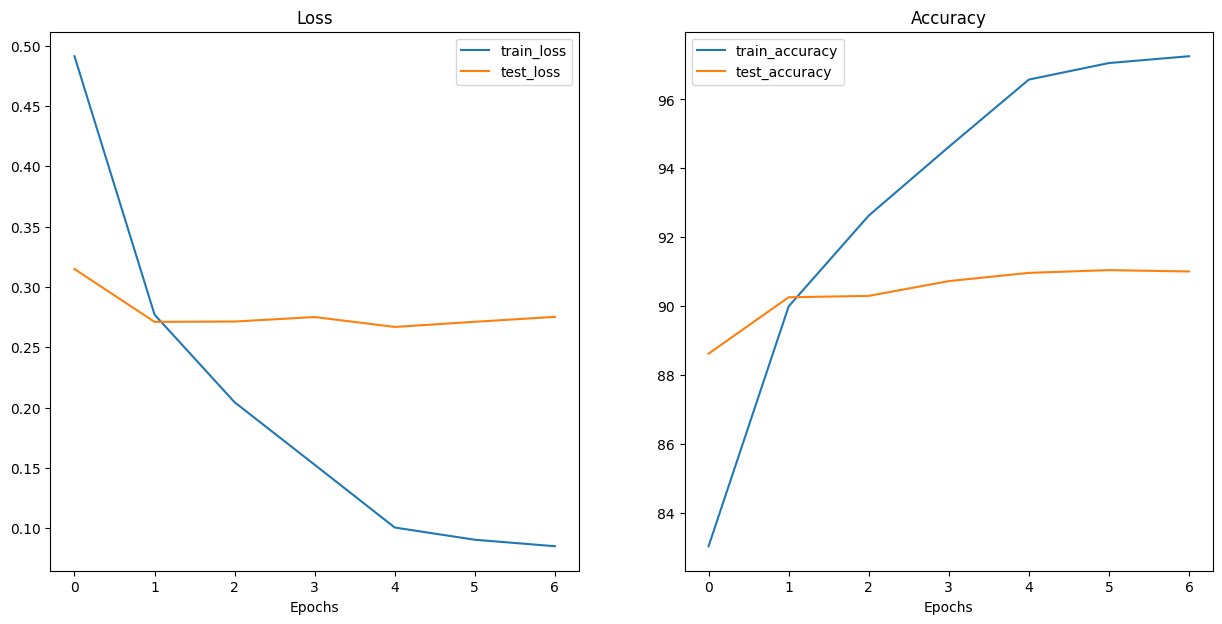

In [182]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary."""
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Setup the figure count
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

# Run the function
plot_loss_curves(results)

100%|██████████| 313/313 [00:06<00:00, 50.70it/s]



Model Results:
Loss: 0.2752 | Accuracy: 91.00%

Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.87      0.86      0.87      1000
           3       0.92      0.88      0.90      1000
           4       0.86      0.86      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.77      0.75      1000
           7       0.96      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:


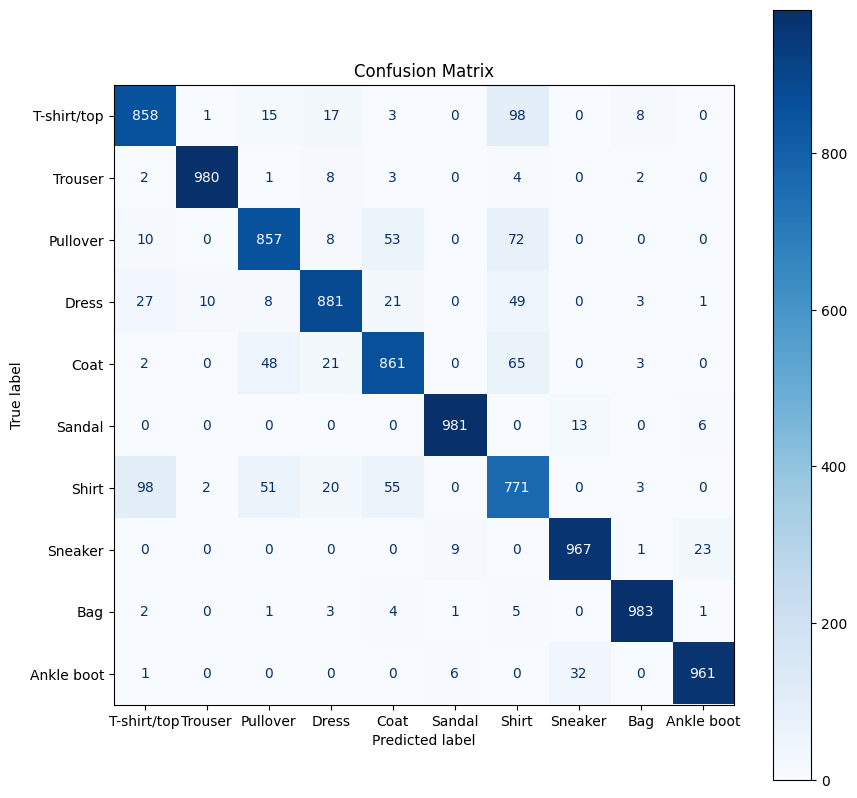

In [183]:
fashionModel.eval()
loss, acc = 0, 0

# Lists to store ALL predictions and ALL true labels
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = fashionModel(X)
        y_pred = y_logits.argmax(dim=1) # Convert logits to class labels

        # Calculate Loss & Accuracy (Running average)
        loss += loss_fn(y_logits, y).item()
        acc += accuracy_fn(y_true=y, y_pred=y_pred)

        # 2. Store predictions/labels for later (Move to CPU first!)
        all_preds.append(y_pred.cpu())
        all_labels.append(y.cpu())

# Calculate average loss/acc
loss /= len(test_dataloader)
acc /= len(test_dataloader)

# Concatenate all batches into single tensors
all_preds_tensor = torch.cat(all_preds)
all_labels_tensor = torch.cat(all_labels)

# Calculate Metrics using Scikit-Learn with 
print(f"\nModel Results:\nLoss: {loss:.4f} | Accuracy: {acc:.2f}%")

print("\nClassification Report (Precision, Recall, F1):")
print(classification_report(all_labels_tensor, all_preds_tensor))

# Plot Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels_tensor, all_preds_tensor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [184]:
# SAVE MODEL

MODEL_PATH = Path("./")
MODEL_NAME = "ResNet18_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=fashionModel.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: ResNet18_FashionMNIST.pth


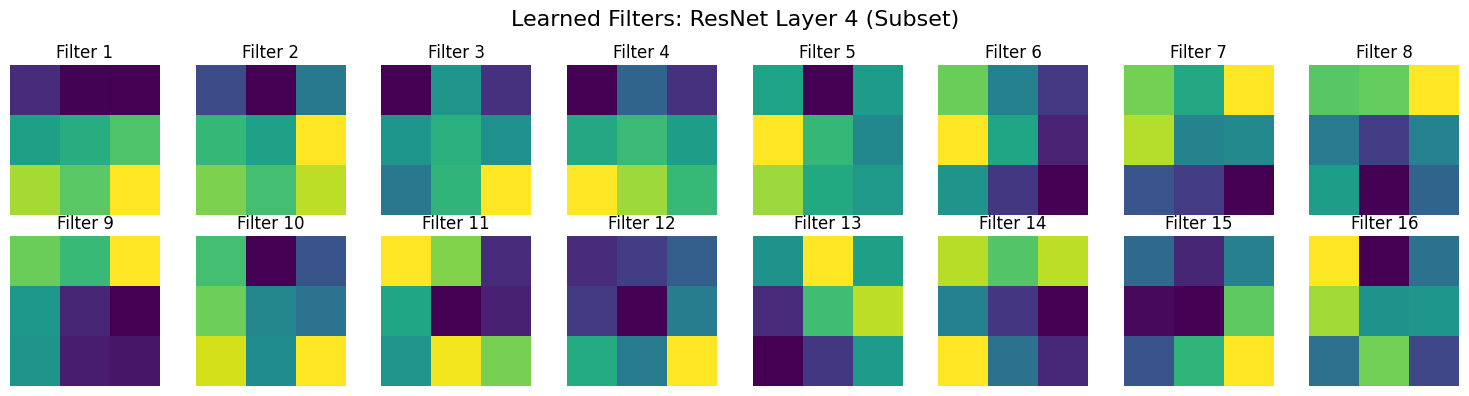

In [185]:
def visualize_resnet_filters(model, num_to_show=16):
    # Access the specific layer weights
    # ResNet structure: model -> layer4 -> Block 0 -> Conv1
    filters = model.layer4[0].conv1.weight.data.cpu().numpy()
    
    # filters shape is [512, 256, 3, 3] (512 filters, depth of 256, 3x3 kernel)
    # We slice to show only the first 'num_to_show' filters because showing 512 is too much
    filters = filters[:num_to_show]
    
    # 2. Setup Plot
    n_columns = 8
    n_rows = num_to_show // n_columns + (num_to_show % n_columns > 0)
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 2 * n_rows))
    fig.suptitle('Learned Filters: ResNet Layer 4 (Subset)', fontsize=16)
    
    # Flatten axes array for easy iteration if multiple rows
    axes = axes.flatten() if num_to_show > 1 else [axes]
    
    for i in range(num_to_show):
        # We take the ith filter.
        # We take channel 0 to visualize it as a 2D image.
        f = filters[i, 0, :, :]
        
        # Plot
        ax = axes[i]
        ax.imshow(f, cmap='viridis') # viridis or gray both work well here
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
        
    # Turn off any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Run the function
visualize_resnet_filters(fashionModel)

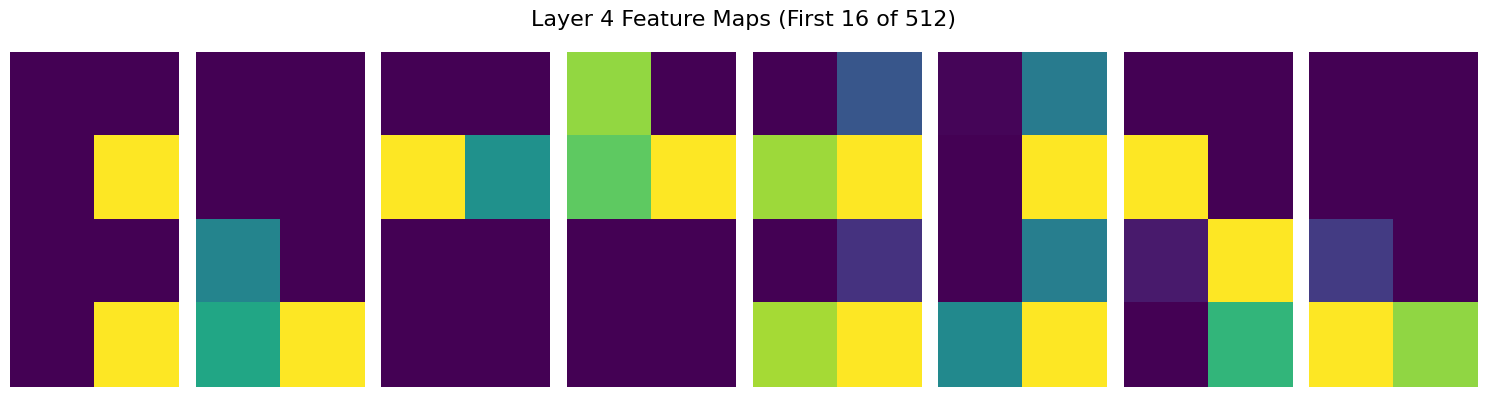

In [186]:
def visualize_feature_maps(model, image, device):
    model.eval()
    
    # 1. Prepare image
    x = image.unsqueeze(0).to(device)
    
    # 2. Pass data through the model MANUALLY until we reach layer 4
    # We must run these first so layer 4 gets the correct processed info
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    
    # 3. Pass through Layer 4 and Capture the result
    # This is the layer we modified and want to visualize
    out_layer4 = model.layer4(x)
    
    # 4. Prepare for plotting
    # Shape is [1, 512, 2, 2] (or [1, 512, 8, 8] if using 224x224 input)
    feature_maps = out_layer4.squeeze(0).detach().cpu()
    
    # LIMIT to first 16 maps (ResNet has 512, which is too many to plot)
    num_maps_to_show = 16
    feature_maps = feature_maps[:num_maps_to_show]
    
    # 5. Plotting Code
    n_columns = 8
    n_rows = num_maps_to_show // n_columns + (num_maps_to_show % n_columns > 0)
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 2 * n_rows))
    fig.suptitle(f'Layer 4 Feature Maps (First {num_maps_to_show} of 512)', fontsize=16)
    
    # Flatten axes for easy looping
    axes = axes.flatten() if num_maps_to_show > 1 else [axes]

    for i in range(num_maps_to_show):
        ax = axes[i]
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the function
sample_img, label = test_data[0] 
visualize_feature_maps(fashionModel, sample_img, device)